### Prediction Model

Data has been already cleaned in SQL.

A database with a timestamp every 5 min was created with the station and weather data.
The day-time savings time change was adjusted.
A column for the day was added.
The status for the night was corrected to closed.
The CSV clean_db.csv was created from that. This database will be used as test and validation set for this prediction model.
Column with just time.

For the prediction model there will be a random forest regression done for each station.

In [1]:
# Import the required packages
# Import package pandas for data analysis
import pandas as pd

# Import package numpy for numeric computing
import numpy as np

# Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt

# Imports for random forest regression
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

# For showing plots directly in the notebook run the command below
%matplotlib inline

# Connect DB
import sys
sys.path.append('../web/')
from dbConnection import connect_db, get_clean_db


# Pickle
import pickle

In [2]:
# Reading from a csv file, into a data frame
df = pd.read_csv("/Users/florian/Documents/GitHub/clean_db.csv", keep_default_na=True, dtype={16: str}, delimiter=',', skipinitialspace=True, encoding='Windows-1252') #sep=',\s+',

In [3]:
#sql_query = get_clean_db()
#df = pd.DataFrame(sql_query, columns = ['timestamp', 'station_id', 'available_bikes', 'available_bike_stands', 'status', 'temperature', 'pressure', 'humidity', 'clouds', 'wind_speed_beaufort', 'wind_direction', 'precipitation_value', 'precipitation_min', 'precipitation_max', 'precipitation_probability', 'wind_speed_mps', 'weather_type', 'icon_number', 'temperature_feels_like', 'day_flag', 'time', 'day'])

In [4]:
print("Rows: " + str(df.shape[0]))
print("Columns: " + str(df.shape[1]))
print(df.columns)
df.dtypes

Rows: 989972
Columns: 22
Index(['timestamp', 'station_id', 'available_bikes', 'available_bike_stands',
       'status', 'temperature', 'pressure', 'humidity', 'clouds',
       'wind_speed_beaufort', 'wind_direction', 'precipitation_value',
       'precipitation_min', 'precipitation_max', 'precipitation_probability',
       'wind_speed_mps', 'weather_type', 'icon_number',
       'temperature_feels_like', 'day_flag', 'time', 'day'],
      dtype='object')


timestamp                     object
station_id                     int64
available_bikes                int64
available_bike_stands          int64
status                        object
temperature                  float64
pressure                     float64
humidity                     float64
clouds                       float64
wind_speed_beaufort            int64
wind_direction               float64
precipitation_value          float64
precipitation_min            float64
precipitation_max            float64
precipitation_probability    float64
wind_speed_mps               float64
weather_type                  object
icon_number                  float64
temperature_feels_like       float64
day_flag                       int64
time                          object
day                           object
dtype: object

### Time Changes

In [5]:
# Type changes & drops
df.drop(['weather_type', 'icon_number'], axis=1, inplace=True)

In [6]:
df["time"] = pd.to_datetime(df["time"], format="%H:%M:%S")
df["time"] = df["time"].dt.strftime("%H:%M:%S")

In [7]:
def to_category(column):
    list_unique = []
    for i in sorted(df[column].unique()):
        list_unique.append(i)

    list_range = [i for i in range(len(list_unique))]
    df[column] = df[column].astype('category')
    df[column].cat.add_categories(list_range, inplace=True)

    df[column] = df[column].replace(list_unique, list_range)
    df[column] = df[column].astype('int64')

In [8]:
to_category("status")
to_category("time")
to_category("day")

/var/folders/ly/rt519r9j7sx5syy44_l85hz80000gn/T/ipykernel_96060/2460517589.py:8: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[column].cat.add_categories(list_range, inplace=True)
/var/folders/ly/rt519r9j7sx5syy44_l85hz80000gn/T/ipykernel_96060/2460517589.py:8: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[column].cat.add_categories(list_range, inplace=True)
/var/folders/ly/rt519r9j7sx5syy44_l85hz80000gn/T/ipykernel_96060/2460517589.py:8: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[column].cat.add_categori

In [9]:
print(df["status"].ravel())
print(df["time"].ravel())
print(df["day"].ravel())
print(df.dtypes)

[1 1 1 ... 1 1 1]
[127 127 127 ... 108 108 108]
[0 0 0 ... 4 4 4]
timestamp                     object
station_id                     int64
available_bikes                int64
available_bike_stands          int64
status                         int64
temperature                  float64
pressure                     float64
humidity                     float64
clouds                       float64
wind_speed_beaufort            int64
wind_direction               float64
precipitation_value          float64
precipitation_min            float64
precipitation_max            float64
precipitation_probability    float64
wind_speed_mps               float64
temperature_feels_like       float64
day_flag                       int64
time                           int64
day                            int64
dtype: object


In [10]:
# Ratio of availability

df['availabilty_ratio'] = df['available_bikes'] / (df['available_bikes'] + df['available_bike_stands'])

In [11]:
df.loc[df['availabilty_ratio'].isnull()]

,timestamp,station_id,available_bikes,available_bike_stands,status,temperature,pressure,humidity,clouds,wind_speed_beaufort,...,precipitation_value,precipitation_min,precipitation_max,precipitation_probability,wind_speed_mps,temperature_feels_like,day_flag,time,day,availabilty_ratio
491568,2023-03-16 14:05:00,30,0,0,1,14.5,994.9,71.3,54.4,3,...,0.0,0.0,0.0,0.0,4.9,14.60,1,169,4,NaN
491682,2023-03-16 14:10:00,30,0,0,1,14.5,994.9,71.3,54.4,3,...,0.0,0.0,0.0,0.0,4.9,14.60,1,170,4,NaN
491796,2023-03-16 14:10:00,30,0,0,1,14.5,994.9,71.3,54.4,3,...,0.0,0.0,0.0,0.0,4.9,14.60,1,170,4,NaN
491903,2023-03-16 14:20:00,23,0,0,1,14.5,994.9,71.3,54.4,3,...,0.0,0.0,0.0,0.0,4.9,14.80,1,172,4,NaN
491910,2023-03-16 14:20:00,30,0,0,1,14.5,994.9,71.3,54.4,3,...,0.0,0.0,0.0,0.0,4.9,14.80,1,172,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582157,2023-03-20 08:45:00,87,0,0,1,12.2,1010.9,82.5,100.0,2,...,0.0,0.0,0.0,0.0,3.2,11.47,1,105,1,NaN
582271,2023-03-20 08:50:00,87,0,0,1,12.2,1010.9,82.5,100.0,2,...,0.0,0.0,0.0,0.0,3.2,11.66,1,106,1,NaN
582385,2023-03-20 08:55:00,87,0,0,1,12.2,1010.9,82.5,100.0,2,...,0.0,0.0,0.0,0.0,3.2,11.65,1,107,1,NaN
582499,2023-03-20 09:10:00,87,0,0,1,13.0,1010.8,78.1,99.7,3,...,0.0,0.0,0.0,5.1,4.1,11.78,1,110,1,NaN


-> Seems to be an error or a time where station is closed if bike and stands is 0. Those rows will be dropped

In [12]:
df = df.loc[df['availabilty_ratio'].notnull()]

In [13]:
df['max_stands'] = df['available_bikes'] + df['available_bike_stands']
stations_unique = sorted(df["station_id"].unique())
for station in stations_unique:
    df_station = df.loc[df["station_id"] == station]
    df_clean_station = df_station.loc[df_station["max_stands"] == df_station["max_stands"].median()]
    print(station, "min:", df_station["max_stands"].min(), "mean:", df_station["max_stands"].median(),"max:", df_station["max_stands"].max(),"-", df_station.shape[0] - df_clean_station.shape[0])

1 min: 28 mean: 31.0 max: 31 - 690
2 min: 19 mean: 20.0 max: 20 - 149
3 min: 18 mean: 20.0 max: 20 - 460
4 min: 19 mean: 20.0 max: 20 - 449
5 min: 38 mean: 40.0 max: 40 - 739
6 min: 12 mean: 20.0 max: 20 - 147
7 min: 28 mean: 29.0 max: 29 - 208
8 min: 26 mean: 30.0 max: 30 - 725
9 min: 21 mean: 24.0 max: 24 - 566
10 min: 14 mean: 16.0 max: 16 - 691
11 min: 28 mean: 30.0 max: 30 - 402
12 min: 19 mean: 20.0 max: 20 - 96
13 min: 27 mean: 30.0 max: 30 - 932
14 min: 27 mean: 30.0 max: 30 - 1082
15 min: 12 mean: 13.0 max: 13 - 179
16 min: 18 mean: 20.0 max: 20 - 553
17 min: 18 mean: 20.0 max: 20 - 794
18 min: 28 mean: 30.0 max: 30 - 944
19 min: 27 mean: 30.0 max: 30 - 1369
20 min: 28 mean: 30.0 max: 30 - 251
21 min: 27 mean: 30.0 max: 30 - 374
22 min: 17 mean: 19.0 max: 19 - 666
23 min: 6 mean: 30.0 max: 30 - 916
24 min: 18 mean: 20.0 max: 20 - 1049
25 min: 27 mean: 30.0 max: 30 - 616
26 min: 18 mean: 20.0 max: 20 - 690
27 min: 18 mean: 20.0 max: 20 - 809
28 min: 29 mean: 30.0 max: 30 - 262


In [14]:
print(df.loc[(df["max_stands"].median()-3 < df["max_stands"]) & (df["max_stands"] < df["max_stands"].median()+3)].shape[0])
print(df.shape[0])

327808
987624


-> Seems like many rows don't add up

In [15]:
for station in stations_unique:
    df.loc[df["station_id"] == station, 'max_stands'] = round(df.loc[df["station_id"] == station, 'max_stands'].median())

for station in stations_unique:
    df_station = df.loc[df["station_id"] == station]
    df_clean_station = df_station.loc[df_station["max_stands"] == df_station["max_stands"].median()]
    print(station, "min:", df_station["max_stands"].min(), "mean:", df_station["max_stands"].median(),"max:", df_station["max_stands"].max(),"-", df_station.shape[0] - df_clean_station.shape[0])

1 min: 31 mean: 31.0 max: 31 - 0
2 min: 20 mean: 20.0 max: 20 - 0
3 min: 20 mean: 20.0 max: 20 - 0
4 min: 20 mean: 20.0 max: 20 - 0
5 min: 40 mean: 40.0 max: 40 - 0
6 min: 20 mean: 20.0 max: 20 - 0
7 min: 29 mean: 29.0 max: 29 - 0
8 min: 30 mean: 30.0 max: 30 - 0
9 min: 24 mean: 24.0 max: 24 - 0
10 min: 16 mean: 16.0 max: 16 - 0
11 min: 30 mean: 30.0 max: 30 - 0
12 min: 20 mean: 20.0 max: 20 - 0
13 min: 30 mean: 30.0 max: 30 - 0
14 min: 30 mean: 30.0 max: 30 - 0
15 min: 13 mean: 13.0 max: 13 - 0
16 min: 20 mean: 20.0 max: 20 - 0
17 min: 20 mean: 20.0 max: 20 - 0
18 min: 30 mean: 30.0 max: 30 - 0
19 min: 30 mean: 30.0 max: 30 - 0
20 min: 30 mean: 30.0 max: 30 - 0
21 min: 30 mean: 30.0 max: 30 - 0
22 min: 19 mean: 19.0 max: 19 - 0
23 min: 30 mean: 30.0 max: 30 - 0
24 min: 20 mean: 20.0 max: 20 - 0
25 min: 30 mean: 30.0 max: 30 - 0
26 min: 20 mean: 20.0 max: 20 - 0
27 min: 20 mean: 20.0 max: 20 - 0
28 min: 30 mean: 30.0 max: 30 - 0
29 min: 29 mean: 29.0 max: 29 - 0
30 min: 20 mean: 20.0 m

## Redo: Ratio:

In [16]:
df['availabilty_ratio'] = df['available_bikes'] / df['max_stands']

In [17]:
def correlation(df):
    # Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
    sns.set(style="white")

    # Calculate correlation of all pairs of continuous features
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom colormap - blue and red
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
                square=True, xticklabels=True, yticklabels=True,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    plt.yticks(rotation = 0)
    plt.xticks(rotation = 45)

In [18]:
df_station = df.loc[df["station_id"] == 1]
#correlation(df_station)
corr = df.corr()
corr

/var/folders/ly/rt519r9j7sx5syy44_l85hz80000gn/T/ipykernel_96060/3102062803.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,station_id,available_bikes,available_bike_stands,status,temperature,pressure,humidity,clouds,wind_speed_beaufort,wind_direction,...,precipitation_min,precipitation_max,precipitation_probability,wind_speed_mps,temperature_feels_like,day_flag,time,day,availabilty_ratio,max_stands
station_id,1.000000,0.069954,0.316350,-0.000120,0.001161,-0.001610,0.000874,-0.000321,-0.000739,0.000260,...,-0.000146,-0.000232,-0.000239,-0.000731,0.001216,-0.000084,0.000045,-0.000846,-0.089985,0.526522
available_bikes,0.069954,1.000000,-0.717159,-0.025263,-0.021311,-0.000416,0.014414,0.000475,-0.001690,-0.001023,...,0.003363,0.001842,0.000828,-0.000981,-0.019580,-0.036942,-0.012830,-0.013079,0.916704,0.220123
available_bike_stands,0.316350,-0.717159,1.000000,0.020921,0.015733,0.000235,-0.012937,-0.002355,0.001444,-0.000442,...,-0.002994,-0.002040,-0.001539,0.001129,0.014439,0.029183,0.012073,0.009193,-0.873082,0.515979
status,-0.000120,-0.025263,0.020921,1.000000,0.150919,0.010461,-0.208519,-0.029357,0.046861,-0.021596,...,0.008488,0.011885,0.004727,0.045742,0.117554,0.466250,0.628188,-0.007621,-0.029271,-0.000096
temperature,0.001161,-0.021311,0.015733,0.150919,1.000000,-0.240283,0.055736,0.030044,0.139247,0.136198,...,-0.173884,-0.080384,-0.034665,0.137001,0.960479,0.273407,0.130750,0.038472,-0.024195,0.000684
pressure,-0.001610,-0.000416,0.000235,0.010461,-0.240283,1.000000,-0.207645,0.049737,-0.458595,-0.274173,...,-0.287117,-0.316247,-0.348712,-0.493536,-0.217657,-0.004994,-0.006521,-0.050660,0.002571,-0.000322
humidity,0.000874,0.014414,-0.012937,-0.208519,0.055736,-0.207645,1.000000,0.257876,0.033070,0.225267,...,0.336262,0.392311,0.442597,0.013000,0.095340,-0.304926,-0.175024,-0.099047,0.022276,0.000463
clouds,-0.000321,0.000475,-0.002355,-0.029357,0.030044,0.049737,0.257876,1.000000,-0.087124,-0.071804,...,0.181464,0.223762,0.260239,-0.112180,0.061678,0.019149,-0.076763,-0.017599,0.001251,-0.000510
wind_speed_beaufort,-0.000739,-0.001690,0.001444,0.046861,0.139247,-0.458595,0.033070,-0.087124,1.000000,0.077898,...,0.298113,0.301210,0.290138,0.957294,0.060903,0.064602,0.047132,0.133833,-0.005167,-0.000972
wind_direction,0.000260,-0.001023,-0.000442,-0.021596,0.136198,-0.274173,0.225267,-0.071804,0.077898,1.000000,...,-0.061068,0.012821,0.051466,0.070058,0.153989,-0.011531,-0.038460,-0.137233,0.000002,-0.000718


/var/folders/ly/rt519r9j7sx5syy44_l85hz80000gn/T/ipykernel_96060/696333702.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_tables.append(df_station.corr())
/var/folders/ly/rt519r9j7sx5syy44_l85hz80000gn/T/ipykernel_96060/3223872616.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


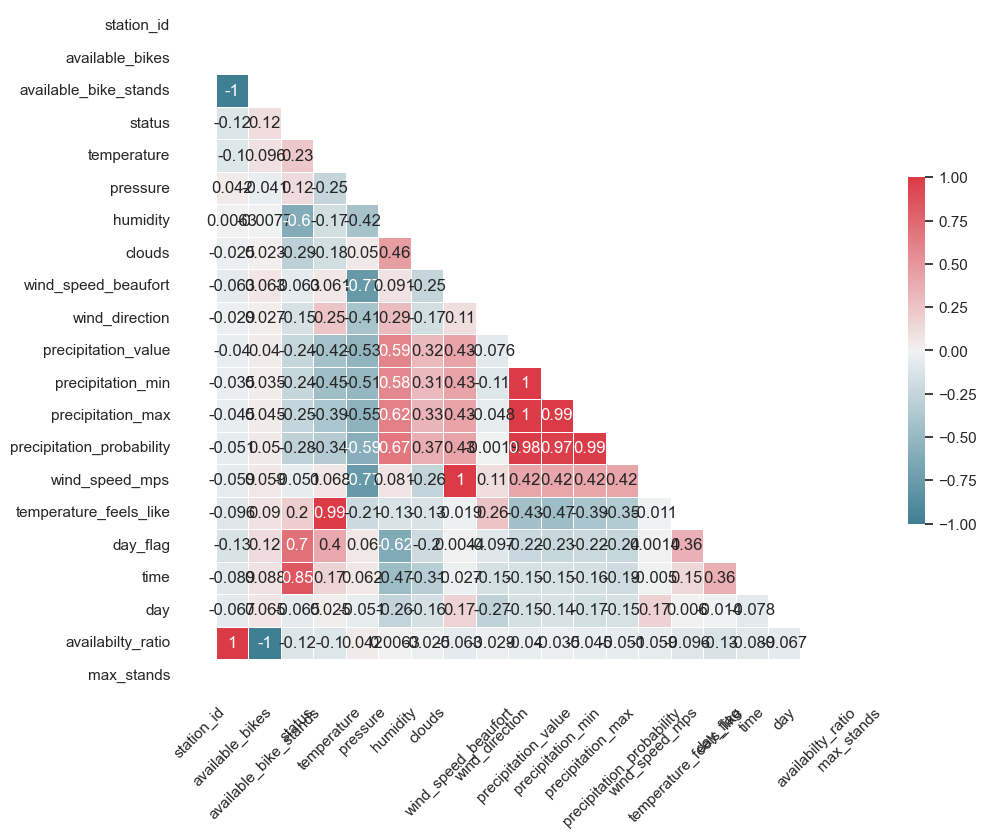

In [19]:
correlation_tables = []
for station in stations_unique:
    df_station = df.loc[df["station_id"] == station]
    correlation_tables.append(df_station.corr())

# Concatenate the correlation tables into a single dataframe
merged_corr_table = pd.concat(correlation_tables)
correlation(merged_corr_table)

# average correlation - in relation to each station

Result:
- precipitation_min / _max / _value seem to represent a similar value with similar correlation. Will be reduced to just the _value.
- wind direction and speed seem to have little influence and will be dropped as well
- all rows with status "CLOSED" will be dropped and then the column will be dropped - not relevant

In [20]:
df = df.loc[df["status"] == 1]
df.drop(['precipitation_min', 'precipitation_max', 'wind_speed_mps', 'wind_direction', 'wind_speed_beaufort', 'status'], axis=1, inplace=True)

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
station_id,813702.0,58.837077,34.133779,1.00,29.000,58.000,89.000000,117.000
available_bikes,813702.0,11.601055,9.424338,0.00,4.000,10.000,17.000000,40.000
available_bike_stands,813702.0,20.110146,10.825623,0.00,12.000,20.000,29.000000,40.000
temperature,813702.0,8.262834,3.236661,0.70,6.200,8.100,10.900000,15.200
pressure,813702.0,1009.745676,15.915381,977.20,996.400,1007.900,1023.700000,1039.400
humidity,813702.0,74.973037,11.410931,30.70,68.300,76.700,83.800000,97.300
clouds,813702.0,79.982633,32.578125,0.00,74.800,99.600,100.000000,100.000
precipitation_value,813702.0,0.114760,0.298696,0.00,0.000,0.000,0.000000,2.800
precipitation_probability,813702.0,15.669883,26.794941,0.00,0.000,1.500,16.700000,100.000
temperature_feels_like,813702.0,5.780204,4.701456,-5.83,2.780,5.010,10.150000,16.040


In [22]:
df.isnull().sum()

timestamp                    0
station_id                   0
available_bikes              0
available_bike_stands        0
temperature                  0
pressure                     0
humidity                     0
clouds                       0
precipitation_value          0
precipitation_probability    0
temperature_feels_like       0
day_flag                     0
time                         0
day                          0
availabilty_ratio            0
max_stands                   0
dtype: int64

In [23]:
# drop temperature_feels_like and day_flag as we don't have them for future values:
df = df.drop(['temperature_feels_like', 'day_flag'],axis=1)

Adding Flag columns for chance:

In [24]:
df['bikes_flag'] = df['available_bikes'].apply(lambda x: 0 if x == 0 else 1)
df['stands_flag'] = df['available_bike_stands'].apply(lambda x: 0 if x == 0 else 1)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
station_id,813702.0,58.837077,34.133779,1.0,29.000,58.000,89.000000,117.000
available_bikes,813702.0,11.601055,9.424338,0.0,4.000,10.000,17.000000,40.000
available_bike_stands,813702.0,20.110146,10.825623,0.0,12.000,20.000,29.000000,40.000
temperature,813702.0,8.262834,3.236661,0.7,6.200,8.100,10.900000,15.200
pressure,813702.0,1009.745676,15.915381,977.2,996.400,1007.900,1023.700000,1039.400
humidity,813702.0,74.973037,11.410931,30.7,68.300,76.700,83.800000,97.300
clouds,813702.0,79.982633,32.578125,0.0,74.800,99.600,100.000000,100.000
precipitation_value,813702.0,0.114760,0.298696,0.0,0.000,0.000,0.000000,2.800
precipitation_probability,813702.0,15.669883,26.794941,0.0,0.000,1.500,16.700000,100.000
time,813702.0,168.969918,70.319121,0.0,113.000,171.000,228.000000,287.000


Historical Data db:

In [25]:
prediction_clean_df = df.drop(['temperature', 'pressure', 'humidity', 'clouds', 'precipitation_value', 'precipitation_probability'],axis=1)
prediction_clean_df.to_csv("prediction_clean_df.csv", index=False)
prediction_clean_df.columns

Index(['timestamp', 'station_id', 'available_bikes', 'available_bike_stands',
       'time', 'day', 'availabilty_ratio', 'max_stands', 'bikes_flag',
       'stands_flag'],
      dtype='object')

In [27]:
# Write clean_db in CSV
df.drop(['timestamp'], axis=1, inplace=True)
df.to_csv("cleaned_clean_db.csv", index=False)

## Random Forest Experiments

As a first test an overall model:

In [ ]:
X = df.drop(['station_id', 'available_bikes', 'available_bike_stands', 'availabilty_ratio', 'max_stands', 'bikes_flag', 'stands_flag'],axis=1)
y = df['availabilty_ratio']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

In [ ]:
regr = RandomForestRegressor(n_estimators = 100, random_state = 42)

In [ ]:
%%time
regr.fit(X_train, y_train)

In [ ]:
# checking the prediction
y_pred = regr.predict(X_test)

print("Mean absolute error:", metrics.mean_absolute_error(y_test, y_pred))
print("Root Mean Square Error:", metrics.mean_squared_error(y_test, y_pred)**0.5)

-> Not really precise. 0.3 root mean square error for a value between 0 and 1.

In [ ]:
plt.scatter(y_test, y_pred)
plt.ylabel('Predicted DT')
plt.xlabel('Actual DT')

-> Prediction seems to be really inaccurate.

#### Random Search Training
Source for following parameter tuning: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
# Best parameters
rf_random.best_params_

#### Evaluate Random Search
To determine if random search yielded a better model, we compare the base model with the best random search model

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    RMSE = metrics.mean_squared_error(test_labels, regr.predict(test_features))**0.5
    errors = abs(predictions - test_labels)
    #mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - (100*RMSE)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('RMSE: {:0.4f}.'.format(RMSE))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = regr
base_accuracy = evaluate(base_model, X_test, y_test)

In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

--> not worth the perfomance needed to improve the model.

### Individual Models

Mean absolute error: 0.018479027009193037
Root Mean Square Error: 0.0341190237454582
Mean absolute error: 0.02393305439330545
Root Mean Square Error: 0.045853140135121026
Mean absolute error: 0.024284053928405405
Root Mean Square Error: 0.04043478831399035
Mean absolute error: 0.02248256624825664
Root Mean Square Error: 0.04307804859289505
Mean absolute error: 0.026473733147373318
Root Mean Square Error: 0.05056393966475713


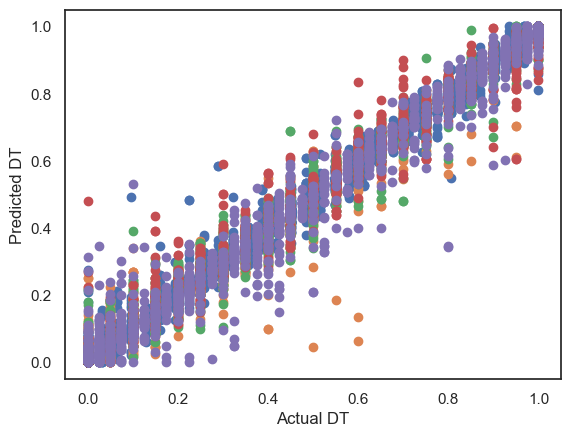

In [29]:
# First test with the first stations and a plot

prediction_models = {}
for station in stations_unique[:5]:
        df_station = df.loc[df["station_id"] == station]
        X = df_station.drop(['station_id', 'available_bikes', 'available_bike_stands', 'availabilty_ratio', 'max_stands', 'bikes_flag', 'stands_flag'],axis=1)
        y = df_station['availabilty_ratio']

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
        
        regr = RandomForestRegressor(n_estimators = 10, random_state = 42)
        regr.fit(X_train, y_train)

        prediction_models[station] = regr

        y_pred = regr.predict(X_test)

        print("Mean absolute error:", metrics.mean_absolute_error(y_test, y_pred))
        print("Root Mean Square Error:", metrics.mean_squared_error(y_test, y_pred)**0.5)

        plt.scatter(y_test, y_pred)
        plt.ylabel('Predicted DT')
        plt.xlabel('Actual DT')

Specific models seem to be much better.

In [ ]:
# Test of training models:
def training(base_model, X_train, X_test, y_train, y_test):
        # Number of trees in random forest
        n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
        # Number of features to consider at every split
        max_features = ['auto', 'sqrt']
        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4]
        # Method of selecting samples for training each tree
        bootstrap = [True, False]
        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

        # Use the random grid to search for best hyperparameters
        # First create the base model to tune
        rf = RandomForestRegressor(random_state = 42)
        # Random search of parameters, using 3 fold cross validation, 
        # search across 100 different combinations, and use all available cores
        rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
        # Fit the random search model
        rf_random.fit(X_train, y_train)

        base_accuracy = evaluate(base_model, X_test, y_test)
        best_random = rf_random.best_estimator_
        random_accuracy = evaluate(best_random, X_test, y_test)
        print('----------------------------------------------------------')
        print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
        print('----------------------------------------------------------')


prediction_models = {}
for station in stations_unique[:5]:
        df_station = df.loc[df["station_id"] == station]
        X = df_station.drop(['station_id', 'available_bikes', 'available_bike_stands', 'availabilty_ratio', 'max_stands'],axis=1)
        y = df_station['availabilty_ratio']

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
        
        regr = RandomForestRegressor(n_estimators = 100, random_state = 42)
        regr.fit(X_train, y_train)

        prediction_models[station] = regr

        y_pred = regr.predict(X_test)

        print("Mean absolute error:", metrics.mean_absolute_error(y_test, y_pred))
        print("Root Mean Square Error:", metrics.mean_squared_error(y_test, y_pred)**0.5)

        training(regr, X_train, X_test, y_train, y_test)


Result: For this sample the training did not improve the accuracy, so we won't train each model to reduce on performance needs.

In [ ]:
prediction_models = {}
for station in stations_unique:
        df_station = df.loc[df["station_id"] == station]
        max_stands = df.loc[df["station_id"] == station]["max_stands"].max()
        X = df_station.drop(['station_id', 'available_bikes', 'available_bike_stands', 'availabilty_ratio', 'max_stands', 'bikes_flag', 'stands_flag'],axis=1)
        y = df_station['availabilty_ratio']
        y_bike_chance = df_station['bikes_flag']
        y_stands_chance = df_station['stands_flag']

        #X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
        
        regr = RandomForestRegressor(n_estimators = 10, random_state = 42)
        regr.fit(X, y)

        regr_bike_chance = RandomForestRegressor(n_estimators = 10, random_state = 42)
        regr_bike_chance.fit(X, y_bike_chance)

        regr_stands_chance = RandomForestRegressor(n_estimators = 10, random_state = 42)
        regr_stands_chance.fit(X, y_stands_chance)

        prediction_models[station] = [regr.predict, max_stands, regr_bike_chance.predict, regr_stands_chance.predict]



In [ ]:
# Test prediction
# ['temperature', 'pressure', 'humidity', 'clouds', 'precipitation_value', 'precipitation_probability', 'time', 'day']
test_values = np.array([[6, 1026.5, 60.4, 79.9, 0, 0, 150, 4]])
pred = prediction_models[1][0](test_values)
pred_chance = prediction_models[1][2](test_values)
pred_stand_chance = prediction_models[1][3](test_values)
print(pred)
print(float(pred_chance))
print(pred_stand_chance)
print(pred * prediction_models[1][1])


In [ ]:
def get_available_bike_prediction(station_id, date, temperature, pressure, humidity, clouds, precipitation_value, precipitation_probability):
   """ date as string: '2023-05-02 23:59:59' """
   # time conversion:
   # hours * 12 + minutes//5 * 1
   time = int(date[11:13]) * 12 + int(date[14:16])//5
   # day conversion:
   d = pd.Timestamp(date[:10])
   day = d.dayofweek

   input_value = np.array([[temperature, pressure, humidity, clouds, precipitation_value, precipitation_probability, time, day]])
   pred = int(prediction_models[station_id][0](input_value))
   pred_bikes = pred * prediction_models[station_id][1]
   pred_stations = prediction_models[station_id][1]-pred_bikes
   return pred_bikes, pred_stations

In [ ]:
bike, stands = get_available_bike_prediction(1, '2023-05-02 23:59:59', 6, 1026.5, 60.4, 79.9, 0, 0)
print(bike, stands)

0 31


/Users/florian/opt/anaconda3/envs/comp30830/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [44]:
# Export function:
with open('predictionModels.pkl', 'wb') as file:
    pickle.dump(prediction_models, file)

In [ ]:
# Code for pickle file per station:
# Too big pickel files
"""
prediction_models = {}
for station in stations_unique:
        df_station = df.loc[df["station_id"] == station]
        max_stands = df.loc[df["station_id"] == station]["max_stands"].max()
        X = df_station.drop(['station_id', 'available_bikes', 'available_bike_stands', 'availabilty_ratio', 'max_stands', 'bikes_flag', 'stands_flag'],axis=1)
        y = df_station['availabilty_ratio']
        y_bike_chance = df_station['bikes_flag']
        y_stands_chance = df_station['stands_flag']
        
        regr = RandomForestRegressor(n_estimators = 100, random_state = 42)
        regr.fit(X, y)

        regr_bike_chance = RandomForestRegressor(n_estimators = 100, random_state = 42)
        regr_bike_chance.fit(X, y_bike_chance)

        regr_stands_chance = RandomForestRegressor(n_estimators = 100, random_state = 42)
        regr_stands_chance.fit(X, y_stands_chance)

        prediction_models[station] = [regr.predict, max_stands, regr_bike_chance.predict, regr_stands_chance.predict]

        with open(f'station_models/predictionModels_{station}.pkl', 'wb') as file:
            pickle.dump([regr.predict, max_stands, regr_bike_chance.predict, regr_stands_chance.predict], file)

"""

In [31]:
# Code for pickle file per station:
prediction_models = {}
for station in stations_unique:
        df_station = df.loc[df["station_id"] == station]
        max_stands = df.loc[df["station_id"] == station]["max_stands"].max()
        X = df_station.drop(['station_id', 'available_bikes', 'available_bike_stands', 'availabilty_ratio', 'max_stands', 'bikes_flag', 'stands_flag'],axis=1)
        y = df_station['availabilty_ratio']
        y_bike_chance = df_station['bikes_flag']
        y_stands_chance = df_station['stands_flag']
        
        regr = RandomForestRegressor(n_estimators = 10, random_state = 42)
        regr.fit(X, y)

        regr_bike_chance = RandomForestRegressor(n_estimators = 10, random_state = 42)
        regr_bike_chance.fit(X, y_bike_chance)

        regr_stands_chance = RandomForestRegressor(n_estimators = 10, random_state = 42)
        regr_stands_chance.fit(X, y_stands_chance)

        prediction_models[station] = [regr.predict, max_stands, regr_bike_chance.predict, regr_stands_chance.predict]

        with open(f'station_models/predictionModels_{station}.pkl', 'wb') as file:
            pickle.dump([regr.predict, max_stands, regr_bike_chance.predict, regr_stands_chance.predict], file)

--------------------------------------